In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('C:/Users/nerpa\Dropbox (Personal)\Research\discrete_sr\code\python\SPIDER_discrete')

In [2]:
import numpy as np

from commons.weight import *
from utils import save, load
from library import *
from process_library_terms import *

In [3]:
import netCDF4 as nc

dataset = 'viscek/dt=1_rho=1_v=0.5_alpha=0.25_eta=0.35_N=100000.nc'
#dataset = 'viscek/dt=1_rho=1_v=0.5_alpha=0.25_eta=0.2_N=100000.nc'
#dataset = 'viscek/dt=1_rho=1_v=0.5_alpha=0.25_eta=0.15_N=100000.nc'
ds = nc.Dataset(dataset)
print(ds)

nt = len(ds.dimensions["time"])
n_particles = len(ds.dimensions["director"])
deltat = 1
v = 0.5
positions = np.array(ds.variables["position"]).T
positions = np.reshape(positions, (n_particles, 2, nt))
positions -= np.min(positions[:]) # recenter positions to [0, L]
directors = np.array(ds.variables["director"])
vs = v*np.stack([np.cos(directors), np.sin(directors)], axis=1).T
print(directors.shape)
print(positions.shape)
print(vs.shape)
dims = [np.max(positions[:]), nt]
world_size = np.array([dims[0], dims[0], dims[1]])
print(world_size)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): Nv(100000), dof(200000), boxdim(4), unit(1), time(50), position(200000), director(100000)
    variables(dimensions): float32 time(time), float32 position(time, position), float32 director(time, director)
    groups: 
(50, 100000)
(100000, 2, 50)
(100000, 2, 50)
[316.22763062 316.22763062  50.        ]


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = 'C:/Users/nerpa/Downloads/ffmpeg-6.0-essentials_build/bin/ffmpeg.exe'

vid_file = 'viscek/eta0.35.mp4'

fig, ax = plt.subplots(figsize=(6, 6))
qv = ax.quiver(positions[:, 0, -1], positions[:, 1, -1], 1, 0, clim=[-np.pi, np.pi])

def animate(i):
    if i % 10 == 0:
        print(i)
    qv.set_offsets(positions[:, :, i])
    norms = np.sqrt(vs[:, 0, i] ** 2 + vs[:, 1, i] ** 2)
    qv.set_UVC(vs[:, 0, i] / norms, vs[:, 1, i] / norms, np.angle(vs[:, 0, i] + 1.0j * vs[:, 1, i]))
    return qv,

anim = FuncAnimation(fig, animate, np.arange(0, positions.shape[-1]), interval=1, blit=True)
FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
anim.save(vid_file, writer=FFwriter, dpi=100)

In [4]:
%%prun # profiling

data_dict = {}
data_dict['v'] = vs
v_obs = Observable('v', 1)
observables = [v_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
kernel_sigma = 2
cg_res = 1
srd = SRDataset(world_size, data_dict, positions, observables, 
                kernel_sigma=kernel_sigma, cg_res=cg_res, deltat=deltat, cutoff=6)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=4, max_observables=3)
#srd.make_libraries(max_complexity=5, max_observables=3)
srd.make_libraries(max_complexity=6, max_observables=4)

dom_width = 80
dom_time = 20 #previously 20 (without interpolation)
srd.make_domains(ndomains=15, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*8) #ndomains = 30
srd.make_weights(m=8, qmax=1)
corr_L = 5
srd.set_LT_scale(L=corr_L, T=corr_L/v) # note that this line must go before make_library_matrices
srd.make_library_matrices(debug=False)

save('Q_XY_0.35.npy', srd.dxs, srd.libs)

         366051988 function calls (302371291 primitive calls) in 59436.712 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      225 57774.879  256.777 58405.027  259.578 process_library_terms.py:213(eval_cgp)
   341640  536.824    0.002  537.584    0.002 diff.py:478(_apply_to_array)
 60000000  412.435    0.000  456.536    0.000 process_library_terms.py:33(line_dist)
     2528  154.942    0.061 59387.216   23.492 process_library_terms.py:326(make_tw_arr)
90397634/30397634   73.874    0.000  545.537    0.000 {built-in method builtins.max}
 90000000   59.228    0.000  515.764    0.000 process_library_terms.py:30(<genexpr>)
        1   48.583   48.583  620.507  620.507 process_library_terms.py:156(find_domain_neighbors)
3869566/1890555   47.840    0.000  152.806    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   113760   42.107    0.000   45.379    0.000 function_base.py:4129(trapz)
   121560  

In [5]:
_, libs = load('Q_XY_0.35.npy', 2)
libs = libs.item()

In [6]:
from identify_models import *
opts = dict()
#opts['threshold'] = "AIC"
opts['threshold'] = "threshold"
#opts['row_norms'] = libs[0].row_weights
opts['method'] = "stepwise"
#opts['method'] = "power"
opts['gamma'] = 2
opts['delta'] = 1e-8#1e-8 # apparently this reaches machine precision as the relative error
opts['anchor_norm'] = np.linalg.norm(libs[0].Q[:, 0])
# note - in the case of higher harmonics we do not have residual = 1 for 1 = 0 as expected.
opts['verbose'] = False
opts['char_sizes'] = libs[0].col_weights#np.linalg.norm(libs[0].Q, axis=0)
opts1 = opts.copy()
opts1['char_sizes'] = libs[1].col_weights#np.linalg.norm(libs[1].Q, axis=0)
#opts1['row_norms'] = libs[1].row_weights

eqs, lambdas, derived_eqs, excluded_terms = interleave_identify([libs[0].Q, libs[1].Q], 
[opts, opts1], [libs[0].terms, libs[1].terms], threshold=1e-2) #1e-3 #1e-2

[0.02 s]
Identified model: -0.2499999999344039 * rho + 1.0 * rho[v_j * v_j] = 0 (order 3, residual 2.70e-10)
[0.06 s]
Identified model: 0.9998228504194007 * dj rho[v_j] + 0.06546224399272695 * dj^2 rho + 1.0 * dt rho + -0.4513983612872643 * dt^2 rho = 0 (order 3, residual 2.09e-04)
[0.05 s]
Identified model: 0.15281226843494855 * 1 + -0.7414645047858339 * rho + 1.0 * rho * rho + -0.46342637489906685 * rho * rho * rho + 0.06759873463235246 * rho * rho * rho * rho = 0 (order 4, residual 4.32e-03)
[0.12 s]
Identified model: -0.7816203472624831 * dt rho + 1.0 * rho * dt rho + -0.2630221483620433 * rho * rho * dt rho = 0 (order 4, residual 7.49e-03)
[0.12 s]
Identified model: 1.0 * rho[v_i * v_j * v_j] + -0.2499999999749427 * rho[v_i] = 0 (order 4, residual 3.77e-10)
[0.22 s]
Identified model: 1.0 * dj rho[v_i * v_j] + -0.21810217744884627 * rho * di rho + 0.0656150638644386 * rho * rho * di rho = 0 (order 4, residual 9.53e-03)
[0.33 s]
Identified model: -0.6995543298589666 * di rho + 1.0 *

In [ ]:
import seaborn as sns
%matplotlib inline
sns.set(rc={'figure.figsize':(14,9)})

# calculate the correlation matrix
R2 = (np.corrcoef(libs[0].Q, rowvar=False)**2)
# plot the heatmap
label_names = [str(term) for term in libs[0].terms]
sns.heatmap(R2, xticklabels=label_names, yticklabels=label_names, annot=True, fmt=".2f")

In [ ]:
def visualize_cgp(srd, vid_file, n_cgp, n_domain, obs_dims=None):
    fig, ax = plt.subplots(figsize=(6, 6))
    cgp = srd.cgps[n_cgp]
    domain = srd.cgps[n_domain]
    if obs_dims is None:
        obs_dims = [0]*cgp.rank
    print(f"Visualizing {cgp} on domain {domain} using dimensions {obs_dims}")
    
    def animate(i):
        if i % 10 == 0:
            print(f"frame={i}")
        ax.imshow(srd.cg_dict[cgp, tuple(obs_dims), domain][i])
        return ax,

    anim = FuncAnimation(fig, animate, np.arange(0, len(domain.times)), interval=1, blit=True)
    FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
    anim.save(vid_file, writer=FFwriter, dpi=100)
    
visualize_cgp(srd, 'viscek/cg_rho_test.mp4', 0, 0)

In [8]:
for i, term, size in zip(list(range(len(libs[0].terms))), libs[0].terms, libs[0].col_weights):
    print(i, term, size, term.complexity)
for i, term, size in zip(list(range(len(libs[1].terms))), libs[1].terms, libs[1].col_weights):
    print(i, term, size, term.complexity)

0 1 1 0
1 rho 1.000000856355482 1
2 dj^2 rho 0.03626008351568262 3
3 dj^2 dk^2 rho 0.0014504033406273046 5
4 dt rho 0.09065020878920654 2
5 dt dj^2 rho 0.003626008351568262 4
6 dt dj^2 dk^2 rho 0.00014504033406273047 6
7 dt^2 rho 0.009065020878920655 3
8 dt^2 dj^2 rho 0.0003626008351568262 5
9 dt^3 rho 0.0009065020878920655 4
10 dt^3 dj^2 rho 3.626008351568262e-05 6
11 dt^4 rho 9.065020878920654e-05 5
12 dt^5 rho 9.065020878920655e-06 6
13 rho * rho 1.0000017127116976 2
14 rho * dj^2 rho 0.03626011456720392 4
15 rho * dj^2 dk^2 rho 0.0014504045826881568 6
16 rho * dt rho 0.09065028641800979 3
17 rho * dt dj^2 rho 0.0036260114567203917 5
18 rho * dt^2 rho 0.00906502864180098 4
19 rho * dt^2 dj^2 rho 0.0003626011456720392 6
20 rho * dt^3 rho 0.0009065028641800979 5
21 rho * dt^4 rho 9.06502864180098e-05 6
22 rho * rho * rho 1.0000025690686463 3
23 rho * rho * dj^2 rho 0.036260145618751814 5
24 rho * rho * dt rho 0.09065036404687953 4
25 rho * rho * dt dj^2 rho 0.0036260145618751813 6
26 

In [16]:
continuity_terms = ['dt rho', 'dj rho[v_j]']
#continuity_terms = ['dt rho', 'dj rho[v_j]', 'dt^2 rho', 'dj^2 rho']

#continuity_terms = ['1', 'rho', 'rho * rho']
#continuity_terms = ['1']
#continuity_terms = ['rho * dt rho', 'rho * dj rho[v_j]']
#continuity_terms = ['dt rho * rho', 'rho * rho * dj v_j', 'dj rho * rho * v_j']
#continuity_terms = ['dt rho', 'dj rv_j']
col_numbers = [find_term(libs[0].terms, name) for name in continuity_terms]
Xi, lambd = regress(libs[0].Q, col_numbers, libs[0].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

[Term 4] 0.9963486270291497 * dt rho. (Char. size: 0.08731595010809375)
[Term 35] 1.0 * dj rho[v_j]. (Char. size: 0.055279803740062486)
Model residual: 0.006783855220839536


In [17]:
print(libs[0].Q[:10, 4], libs[0].Q[:10, 35])

[  3.66913194 -11.08253818  19.18466422 -19.99752286 -16.9463906
 -80.80038207 -93.18971136  -8.76097935  -6.27882157 -22.63899937] [ -3.81864456  11.2169998  -19.87822595  20.23997705  17.15761192
  80.33908708  92.76504889   8.84609603   5.53917348  22.48440001]


frame=0
frame=0
frame=0


MovieWriter stderr:
[out#0/mp3 @ 000001fd2d9ee780] Output file does not contain any stream



CalledProcessError: Command '['C:/Users/nerpa/Downloads/ffmpeg-6.0-essentials_build/bin/ffmpeg.exe', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-r', '24', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'libx264', '-y', 'viz_test.mp3']' returned non-zero exit status 1.

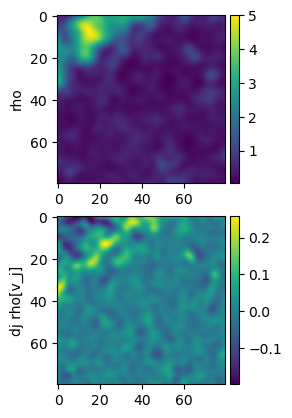

In [9]:
### plot strong-form fields

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = 'C:/Users/nerpa/Downloads/ffmpeg-6.0-essentials_build/bin/ffmpeg.exe'

vid_file = 'viz_test.mp3'

zero_arr = [0] * srd.n_dimensions
constant_weight = Weight(m=zero_arr, q=zero_arr, k=zero_arr) # should evaluate to 1 everywhere

def make_residual_arr(equation, domain, kc):
    arrs = [c*srd.make_tw_arr(term, constant_weight, [domain], kc, by_parts=False) 
            for term, c in zip(equation.term_list, equation.coeffs)]
    return sum(arrs)[..., 0]

domain = srd.domains[0]
kc = None # can select x, y components

term1 = srd.libs[0].terms[find_term(libs[0].terms, 'rho')]
tw_arr = srd.make_tw_arr(term1, constant_weight, [domain], kc, by_parts=False)[..., 0]
fig, (ax1, ax2) = plt.subplots(2, 1)
im1 = ax1.imshow(tw_arr[:, :, 0])
#colorbar
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(im1, cax=cax1)

term2 = srd.libs[0].terms[find_term(libs[0].terms, 'dj rho[v_j]')]
tw_arr2 = srd.make_tw_arr(term2, constant_weight, [domain], kc, by_parts=False)[..., 0]
im2 = ax2.imshow(tw_arr2[:, :, 0])
#colorbar
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cb2 = plt.colorbar(im2, cax=cax2)

ax1.set_ylabel(str(term1))
ax2.set_ylabel(str(term2))

def animate(i):
    if i % 10 == 0:
        print(f"frame={i}")
    im1.set_array(tw_arr[:, :, i])
    im2.set_array(tw_arr2[:, :, i])
    vmax1 = np.max(tw_arr[:, :, i])
    vmin1 = np.min(tw_arr[:, :, i])
    vmax2 = np.max(tw_arr2[:, :, i])
    vmin2 = np.min(tw_arr2[:, :, i])
    im1.set_clim(vmin1, vmax1)
    im2.set_clim(vmin2, vmax2)

    return im1, im2

anim = FuncAnimation(fig, animate, np.arange(0, len(domain.times)), interval=1, blit=True)
FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
anim.save(vid_file, writer=FFwriter, dpi=100)

plt.show()

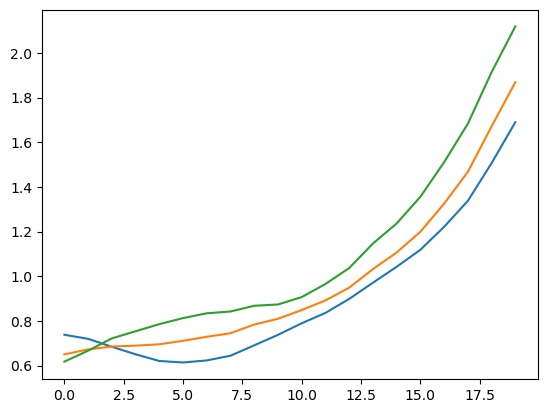

In [10]:
fig, ax = plt.subplots(1, 1)
ax.plot(tw_arr[0, 0, :])
ax.plot(tw_arr[1, 0, :])
ax.plot(tw_arr[2, 0, :])

In [11]:
constraint_terms = ['rho', 'rho[v_j * v_j]']
col_numbers = [find_term(libs[0].terms, name) for name in constraint_terms]
Xi, lambd = regress(libs[0].Q, col_numbers, libs[0].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

[Term 1] -0.2499999999344039 * rho. (Char. size: 1.000000856355482)
[Term 48] 1.0 * rho[v_j * v_j]. (Char. size: 0.12500012244364367)
Model residual: 2.8428972318079173e-10


In [12]:
wave_terms = ['dt^2 rho', 'dj^2 rho']
col_numbers = [find_term(libs[0].terms, name) for name in wave_terms]
Xi, lambd = regress(libs[0].Q, col_numbers, libs[0].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)

[Term 2] -0.16957365558855353 * dj^2 rho. (Char. size: 0.0349263800432375)
[Term 7] 1.0 * dt^2 rho. (Char. size: 0.008731595010809374)
Model residual: 0.44615792803835586


In [13]:
burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]']
#burger_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'di rho']#, 'dj^2 rho[v_i]']# 'dj^2 rho[v_i]']
#burger_terms = ['dt rho[v_i]', 'rho * dj rho[v_i * v_j]', 'di rho']
col_numbers = [find_term(libs[1].terms, name) for name in burger_terms]
Xi, lambd = regress(libs[1].Q, col_numbers, libs[1].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

[Term 27] 0.9666842859844947 * dt rho[v_i]. (Char. size: 0.027639901870031243)
[Term 52] 1.0 * dj rho[v_i * v_j]. (Char. size: 0.017498845845213815)
Model residual: 0.34753878805908966


In [14]:
#euler_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'di rho']
euler_terms = ['dj rho[v_i * v_j]', 'di rho']
col_numbers = [find_term(libs[1].terms, name) for name in euler_terms]
Xi, lambd = regress(libs[1].Q, col_numbers, libs[1].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

[Term 0] -0.144464487943609 * di rho. (Char. size: 0.1746319002161875)
[Term 52] 1.0 * dj rho[v_i * v_j]. (Char. size: 0.017498845845213815)
Model residual: 0.07008764352876362


In [15]:
toner_tu_terms = ['dt rho[v_i]', 'dj rho[v_i * v_j]', 'rho[v_i] * dj rho[v_j]', 'rho[v_i]',
                'di rho', 'dj^2 rho[v_i]', 'di dj rho[v_j]']
#, 'dj dk rho[v_i * v_j * v_k]'], 'rho * di rho', 'rho * rho * di rho'
# third term is a bit sketchy
col_numbers = [find_term(libs[1].terms, name) for name in toner_tu_terms]
Xi, lambd = regress(libs[1].Q, col_numbers, libs[1].col_weights, normalization=opts['anchor_norm'])
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[1].terms[i]}. (Char. size: {libs[1].col_weights[i]})")
print("Model residual:", lambd)

[Term 0] -0.13297151104643046 * di rho. (Char. size: 0.1746319002161875)
[Term 22] 0.0006017131640512392 * rho[v_i]. (Char. size: 0.3535537151384267)
[Term 23] 0.35485640894124554 * di dj rho[v_j]. (Char. size: 0.011055960748012496)
[Term 24] -0.2466107974564232 * dj^2 rho[v_i]. (Char. size: 0.011055960748012496)
[Term 27] -0.02128449557594023 * dt rho[v_i]. (Char. size: 0.027639901870031243)
[Term 52] 1.0 * dj rho[v_i * v_j]. (Char. size: 0.017498845845213815)
[Term 60] -0.100550919001591 * rho[v_i] * dj rho[v_j]. (Char. size: 0.019544379984422187)
Model residual: 0.054396383088473714


In [ ]:
0.03 (0.99998), 0.018, 0.12, 0.08